# NLST CT Acquisition Parameter Analysis

This notebook analyzes DICOM CT acquisition parameter distributions from the NLST (National Lung Screening Trial) collection in IDC to identify a representative subset that covers the variety of acquisitions.

**Data Source:** `bigquery-public-data.idc_current.dicom_all`

**Key DICOM attributes analyzed:**
- Spatial Resolution: SliceThickness, PixelSpacing, SpacingBetweenSlices
- Contrast/Exposure: KVP, Exposure, CTDIvol
- Reconstruction: ConvolutionKernel
- Hardware: Manufacturer, ManufacturerModelName
- Geometry: PatientPosition, GantryDetectorTilt, SpiralPitchFactor

## Section 1: Setup & BigQuery Connection

In [ ]:
# Install dependencies if needed (uncomment to run)
# %pip install --upgrade google-cloud-bigquery pandas matplotlib seaborn scipy scikit-learn

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import warnings
warnings.filterwarnings('ignore')
my_ProjectID = "idc-external-031"

import os
os.environ["GCP_PROJECT_ID"] = my_ProjectID

from google.colab import auth
auth.authenticate_user()

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('colorblind')

In [ ]:
# Configuration
CONFIG = {
    'project_id': "idc-external-031",  # Set to your GCP project ID, or None for default credentials
    'collection_id': 'nlst',
    'table': 'bigquery-public-data.idc_current.dicom_all',
    'modality': 'CT',
    'n_representatives_per_cluster': 10,  # Number of representative series per cluster
    'min_completeness_pct': 20,  # Minimum % non-null values to include a column (exclude if >80% null)
}

# Key DICOM attributes to analyze (will be filtered by completeness after data loading)
DICOM_ATTRIBUTES = {
    'spatial': ['SliceThickness', 'PixelSpacing', 'SpacingBetweenSlices'],
    'exposure': ['KVP', 'Exposure', 'CTDIvol'],
    'reconstruction': ['ConvolutionKernel'],
    'hardware': ['Manufacturer', 'ManufacturerModelName'],
    'geometry': ['PatientPosition', 'GantryDetectorTilt', 'SpiralPitchFactor'],
}

In [ ]:
# Initialize BigQuery client
def get_bq_client(project_id=None):
    """Initialize BigQuery client with optional project ID."""
    if project_id:
        return bigquery.Client(project=project_id)
    return bigquery.Client()

client = get_bq_client(CONFIG['project_id'])
print(f"Connected to BigQuery. Project: {client.project}")

Connected to BigQuery. Project: idc-external-031


In [ ]:
# Helper functions
def run_query(query, client=client):
    """Execute BigQuery query and return DataFrame."""
    job = client.query(query)
    return job.to_dataframe()

def estimate_query_cost(query, client=client):
    """Estimate query cost before execution (dry run)."""
    job_config = bigquery.QueryJobConfig(dry_run=True)
    job = client.query(query, job_config=job_config)
    bytes_processed = job.total_bytes_processed
    gb_processed = bytes_processed / 1e9
    estimated_cost = gb_processed * 5 / 1000  # $5 per TB
    print(f"Query will scan {gb_processed:.2f} GB (estimated cost: ${estimated_cost:.4f})")
    return bytes_processed

def safe_float(col):
    """SQL expression to safely cast column to FLOAT64."""
    return f"SAFE_CAST({col} AS FLOAT64)"

## Section 2: Initial Exploration

In [ ]:

query_counts = f"""
SELECT
  COUNT(*) as total_instances,
  COUNT(DISTINCT PatientID) as unique_patients,
  COUNT(DISTINCT StudyInstanceUID) as unique_studies,
  COUNT(DISTINCT SeriesInstanceUID) as unique_series
FROM `{CONFIG['table']}`
WHERE collection_id = '{CONFIG['collection_id']}'
  AND Modality = '{CONFIG['modality']}'
"""

estimate_query_cost(query_counts)
counts_df = run_query(query_counts)
print("\nNLST CT Collection Summary:")
print(counts_df.T.to_string())

Query will scan 7.13 GB (estimated cost: $0.0357)

NLST CT Collection Summary:
                        0
total_instances  21080927
unique_patients     26254
unique_studies      73113
unique_series      203087


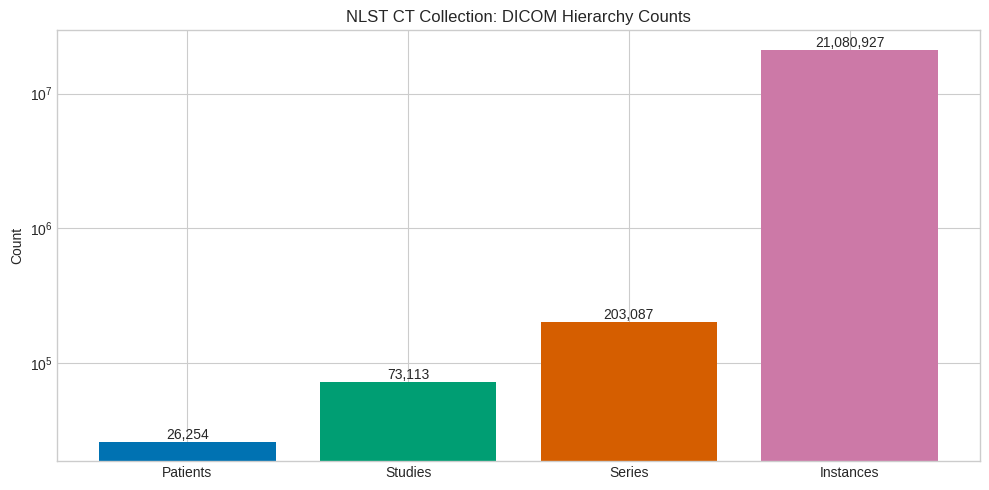

In [ ]:
# Visualize hierarchy counts
fig, ax = plt.subplots(figsize=(10, 5))
levels = ['Patients', 'Studies', 'Series', 'Instances']
values = [counts_df['unique_patients'].iloc[0],
          counts_df['unique_studies'].iloc[0],
          counts_df['unique_series'].iloc[0],
          counts_df['total_instances'].iloc[0]]

bars = ax.bar(levels, values, color=['#0072B2', '#009E73', '#D55E00', '#CC79A7'])
ax.set_ylabel('Count')
ax.set_title('NLST CT Collection: DICOM Hierarchy Counts')
ax.set_yscale('log')

# Add value labels
for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{val:,}',
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
# Query 2.2: Check attribute completeness
all_attributes = (DICOM_ATTRIBUTES['spatial'] + DICOM_ATTRIBUTES['exposure'] +
                  DICOM_ATTRIBUTES['reconstruction'] + DICOM_ATTRIBUTES['hardware'] +
                  DICOM_ATTRIBUTES['geometry'])

completeness_queries = []
for attr in all_attributes:
    completeness_queries.append(
        f"SELECT '{attr}' as attribute, COUNT({attr}) as non_null_count, "
        f"COUNT(*) - COUNT({attr}) as null_count "
        f"FROM `{CONFIG['table']}` "
        f"WHERE collection_id = '{CONFIG['collection_id']}' AND Modality = '{CONFIG['modality']}'"
    )

query_completeness = " UNION ALL ".join(completeness_queries)
completeness_df = run_query(query_completeness)
completeness_df['completeness_pct'] = (completeness_df['non_null_count'] /
                                        (completeness_df['non_null_count'] + completeness_df['null_count']) * 100)
print("Attribute Completeness:")
print(completeness_df.to_string(index=False))

Attribute Completeness:
            attribute  non_null_count  null_count  completeness_pct
              CTDIvol               0    21080927               0.0
      PatientPosition               0    21080927               0.0
                  KVP        21080415         512         99.997571
             Exposure        21060319       20608         99.902243
   GantryDetectorTilt        21080401         526         99.997505
    ConvolutionKernel        21080927           0             100.0
ManufacturerModelName        21080927           0             100.0
         Manufacturer        21080927           0             100.0
    SpiralPitchFactor         5496023    15584904         26.071069
 SpacingBetweenSlices               0    21080927               0.0
       SliceThickness        21080415         512         99.997571
         PixelSpacing        21080927           0             100.0


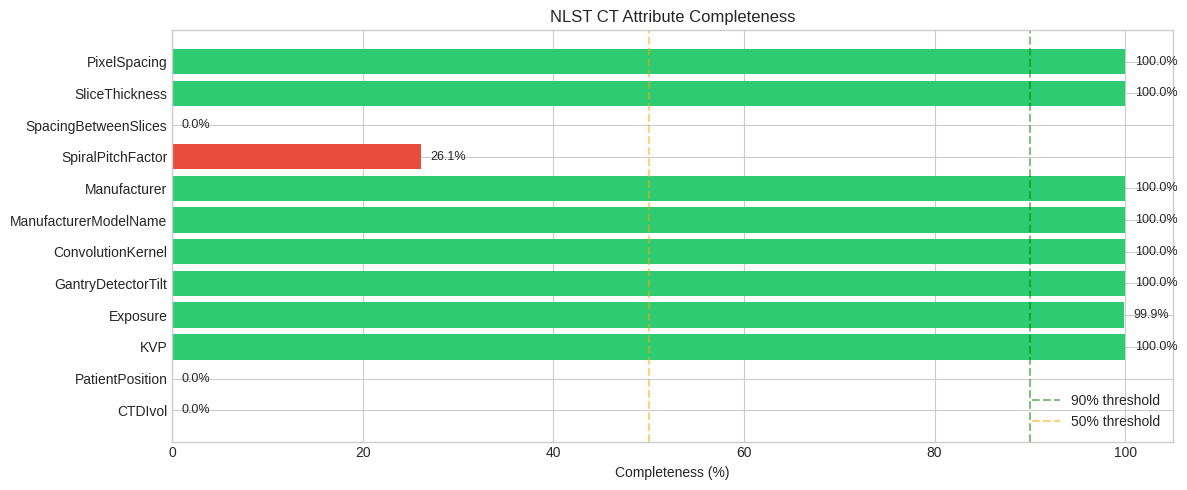

In [ ]:
# Visualize attribute completeness
fig, ax = plt.subplots(figsize=(12, 5))

colors = ['#2ecc71' if pct > 90 else '#f39c12' if pct > 50 else '#e74c3c'
          for pct in completeness_df['completeness_pct']]

bars = ax.barh(completeness_df['attribute'], completeness_df['completeness_pct'], color=colors)
ax.set_xlabel('Completeness (%)')
ax.set_title('NLST CT Attribute Completeness')
ax.set_xlim(0, 105)

# Add percentage labels
for bar, pct in zip(bars, completeness_df['completeness_pct']):
    ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, f'{pct:.1f}%',
            ha='left', va='center', fontsize=9)

ax.axvline(x=90, color='green', linestyle='--', alpha=0.5, label='90% threshold')
ax.axvline(x=50, color='orange', linestyle='--', alpha=0.5, label='50% threshold')
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [ ]:
# Query 2.3: Series-level summary (main data extraction)
query_series = f"""
SELECT
  SeriesInstanceUID,
  PatientID,
  StudyInstanceUID,
  Manufacturer,
  ManufacturerModelName,
  {safe_float('SliceThickness')} as SliceThickness,
  {safe_float('SpacingBetweenSlices')} as SpacingBetweenSlices,
  #SAFE_CAST(SPLIT(PixelSpacing, '\\\\')[OFFSET(0)] AS FLOAT64) as PixelSpacing_Row,
  {safe_float ('PixelSpacing[SAFE_OFFSET(0)]')} as PixelSpacing_Row,
  {safe_float('KVP')} as KVP,
  {safe_float('Exposure')} as Exposure,
  {safe_float('CTDIvol')} as CTDIvol,
  ConvolutionKernel,
  PatientPosition,
  {safe_float('GantryDetectorTilt')} as GantryDetectorTilt,
  {safe_float('SpiralPitchFactor')} as SpiralPitchFactor,
  COUNT(*) as instance_count
FROM `{CONFIG['table']}`
WHERE collection_id = '{CONFIG['collection_id']}'
  AND Modality = '{CONFIG['modality']}'
GROUP BY
  SeriesInstanceUID, PatientID, StudyInstanceUID,
  Manufacturer, ManufacturerModelName,
  SliceThickness, SpacingBetweenSlices, PixelSpacing,
  KVP, Exposure, CTDIvol,
  ConvolutionKernel, PatientPosition, GantryDetectorTilt, SpiralPitchFactor
"""

print("Fetching series-level data...")
estimate_query_cost(query_series)
series_df = run_query(query_series)
print(f"\nRetrieved {len(series_df):,} series")
print(f"\nDataFrame shape: {series_df.shape}")
print(f"\nColumn types:\n{series_df.dtypes}")

Fetching series-level data...
Query will scan 10.66 GB (estimated cost: $0.0533)

Retrieved 216,611 series

DataFrame shape: (216611, 16)

Column types:
SeriesInstanceUID         object
PatientID                 object
StudyInstanceUID          object
Manufacturer              object
ManufacturerModelName     object
SliceThickness           float64
SpacingBetweenSlices     float64
PixelSpacing_Row         float64
KVP                      float64
Exposure                 float64
CTDIvol                  float64
ConvolutionKernel         object
PatientPosition           object
GantryDetectorTilt       float64
SpiralPitchFactor        float64
instance_count             Int64
dtype: object


In [ ]:
# Preview the data
series_df.head(10)

,SeriesInstanceUID,PatientID,StudyInstanceUID,Manufacturer,ManufacturerModelName,SliceThickness,SpacingBetweenSlices,PixelSpacing_Row,KVP,Exposure,CTDIvol,ConvolutionKernel,PatientPosition,GantryDetectorTilt,SpiralPitchFactor,instance_count
0,1.3.6.1.4.1.14519.5.2.1.7009.9004.212885105949...,216489,1.3.6.1.4.1.14519.5.2.1.7009.9004.217101706808...,GE MEDICAL SYSTEMS,Discovery LS,2.500000,NaN,0.628906,120.0,958.0,NaN,[STANDARD],None,0.0,NaN,172
1,1.2.840.113654.2.55.21312615026486325514674206...,125043,1.2.840.113654.2.55.30632337744559825211271695...,GE MEDICAL SYSTEMS,CT scan,410.181793,NaN,0.545455,120.0,41.0,NaN,[EXPERIMENTAL7],None,0.0,NaN,2
2,1.3.6.1.4.1.14519.5.2.1.7009.9004.311239614217...,204498,1.3.6.1.4.1.14519.5.2.1.7009.9004.140182373893...,GE MEDICAL SYSTEMS,LightSpeed VCT,435.000000,NaN,0.545455,120.0,132.0,NaN,[STANDARD],None,0.0,NaN,1
3,1.3.6.1.4.1.14519.5.2.1.7009.9004.191406271762...,203042,1.3.6.1.4.1.14519.5.2.1.7009.9004.153919887091...,GE MEDICAL SYSTEMS,Discovery LS,2.500000,NaN,0.669922,120.0,1017.0,NaN,[STANDARD],None,0.0,NaN,183
4,1.3.6.1.4.1.14519.5.2.1.7009.9004.310423376984...,203576,1.3.6.1.4.1.14519.5.2.1.7009.9004.216790108463...,GE MEDICAL SYSTEMS,Discovery LS,2.500000,NaN,0.625000,120.0,851.0,NaN,[STANDARD],None,0.0,NaN,152
5,1.3.6.1.4.1.14519.5.2.1.7009.9004.181301974499...,215623,1.3.6.1.4.1.14519.5.2.1.7009.9004.138169024668...,GE MEDICAL SYSTEMS,Discovery QX/i,400.181793,NaN,0.545455,120.0,40.0,NaN,[EXPERIMENTAL7],None,0.0,NaN,1
6,1.3.6.1.4.1.14519.5.2.1.7009.9004.134229063432...,208536,1.3.6.1.4.1.14519.5.2.1.7009.9004.394949091166...,GE MEDICAL SYSTEMS,Discovery LS,2.500000,NaN,0.742188,120.0,2002.0,NaN,[STANDARD],None,0.0,NaN,180
7,1.3.6.1.4.1.14519.5.2.1.7009.9004.250051784101...,210984,1.3.6.1.4.1.14519.5.2.1.7009.9004.209559010167...,Philips,Mx8000 IDT,2.000000,NaN,0.625000,120.0,50.0,NaN,[C],None,0.0,NaN,142
8,1.3.6.1.4.1.14519.5.2.1.7009.9004.253634499377...,203874,1.3.6.1.4.1.14519.5.2.1.7009.9004.106685095754...,GE MEDICAL SYSTEMS,Discovery LS,2.500000,NaN,0.619141,120.0,867.0,NaN,[STANDARD],None,0.0,NaN,155
9,1.3.6.1.4.1.14519.5.2.1.7009.9004.783360584960...,211619,1.3.6.1.4.1.14519.5.2.1.7009.9004.202352680026...,GE MEDICAL SYSTEMS,QX/i,430.181824,NaN,0.545455,80.0,43.0,NaN,[STANDARD],None,0.0,NaN,2


In [ ]:
# Check column completeness and filter out columns with >80% null values
def check_column_completeness(df, min_pct=20):
    """
    Check completeness of each column and return lists of usable columns.

    Args:
        df: DataFrame to check
        min_pct: Minimum percentage of non-null values required (default 20%, i.e., exclude if >80% null)

    Returns:
        dict with 'usable' and 'excluded' column lists, and completeness DataFrame
    """
    completeness = []
    for col in df.columns:
        if col in ['SeriesInstanceUID', 'PatientID', 'StudyInstanceUID', 'instance_count']:
            continue  # Skip identifier columns

        total = len(df)
        non_null = df[col].notna().sum()
        pct = (non_null / total) * 100 if total > 0 else 0

        completeness.append({
            'column': col,
            'non_null_count': non_null,
            'null_count': total - non_null,
            'completeness_pct': pct,
            'usable': pct >= min_pct
        })

    completeness_df = pd.DataFrame(completeness).sort_values('completeness_pct', ascending=False)

    usable = completeness_df[completeness_df['usable']]['column'].tolist()
    excluded = completeness_df[~completeness_df['usable']]['column'].tolist()

    return {'usable': usable, 'excluded': excluded, 'completeness_df': completeness_df}

# Check completeness of loaded data
completeness_result = check_column_completeness(series_df, min_pct=CONFIG['min_completeness_pct'])

print(f"Column Completeness (threshold: {CONFIG['min_completeness_pct']}% non-null):")
print("=" * 70)
print(completeness_result['completeness_df'].to_string(index=False))
print()
print(f"USABLE columns ({len(completeness_result['usable'])}): {completeness_result['usable']}")
print(f"EXCLUDED columns ({len(completeness_result['excluded'])}): {completeness_result['excluded']}")

# Update DICOM_ATTRIBUTES to only include usable columns
USABLE_COLUMNS = set(completeness_result['usable'])

DICOM_ATTRIBUTES_FILTERED = {}
for category, attrs in DICOM_ATTRIBUTES.items():
    # Map attribute names to their DataFrame column names
    col_mapping = {
        'PixelSpacing': 'PixelSpacing_Row',  # PixelSpacing is extracted as PixelSpacing_Row
    }
    filtered_attrs = []
    for attr in attrs:
        col_name = col_mapping.get(attr, attr)
        if col_name in USABLE_COLUMNS:
            filtered_attrs.append(col_name)
    if filtered_attrs:
        DICOM_ATTRIBUTES_FILTERED[category] = filtered_attrs

print()
print("Filtered DICOM_ATTRIBUTES (only usable columns):")
for cat, attrs in DICOM_ATTRIBUTES_FILTERED.items():
    print(f"  {cat}: {attrs}")

Column Completeness (threshold: 20% non-null):
               column  non_null_count  null_count  completeness_pct  usable
         Manufacturer          216611           0        100.000000    True
ManufacturerModelName          216611           0        100.000000    True
    ConvolutionKernel          216611           0        100.000000    True
       SliceThickness          216608           3         99.998615    True
                  KVP          216608           3         99.998615    True
     PixelSpacing_Row          216608           3         99.998615    True
   GantryDetectorTilt          216605           6         99.997230    True
             Exposure          211424        5187         97.605385    True
    SpiralPitchFactor           40477      176134         18.686493   False
 SpacingBetweenSlices               0      216611          0.000000   False
              CTDIvol               0      216611          0.000000   False
      PatientPosition               0    

## Section 3: Distribution Analysis

### 3.1 Spatial Resolution Parameters

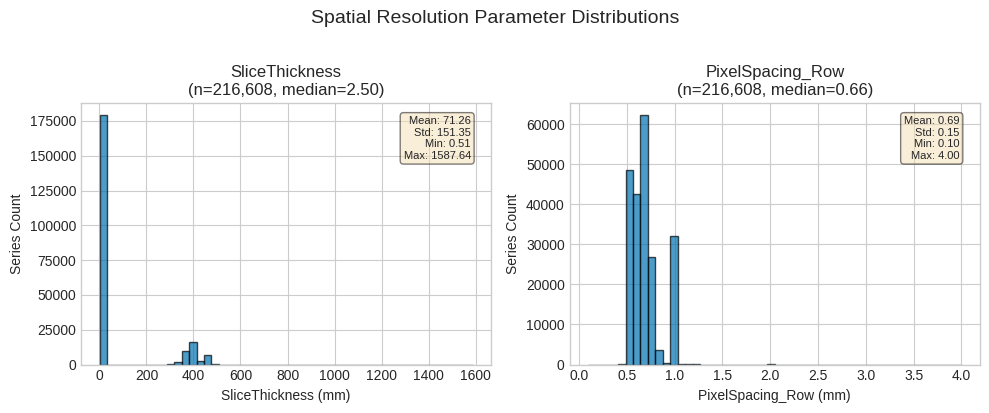

Spatial columns used: ['SliceThickness', 'PixelSpacing_Row']


In [ ]:
# Spatial resolution distributions
# Use filtered spatial columns (excludes columns with >80% null values)
spatial_cols = DICOM_ATTRIBUTES_FILTERED.get('spatial', [])
if not spatial_cols:
    print("Warning: No usable spatial columns available")
else:
    n_cols = len(spatial_cols)
    fig, axes = plt.subplots(1, n_cols, figsize=(5*n_cols, 4))
    if n_cols == 1:
        axes = [axes]

    for i, col in enumerate(spatial_cols):
        ax = axes[i]
        data = series_df[col].dropna()

        ax.hist(data, bins=50, edgecolor='black', alpha=0.7, color='#0072B2')
        ax.set_xlabel(f'{col} (mm)')
        ax.set_ylabel('Series Count')
        ax.set_title(f'{col}\n(n={len(data):,}, median={data.median():.2f})')

        # Add statistics
        stats_text = f'Mean: {data.mean():.2f}\nStd: {data.std():.2f}\nMin: {data.min():.2f}\nMax: {data.max():.2f}'
        ax.text(0.95, 0.95, stats_text, transform=ax.transAxes,
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5), fontsize=8)

    plt.suptitle('Spatial Resolution Parameter Distributions', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

    print(f"Spatial columns used: {spatial_cols}")

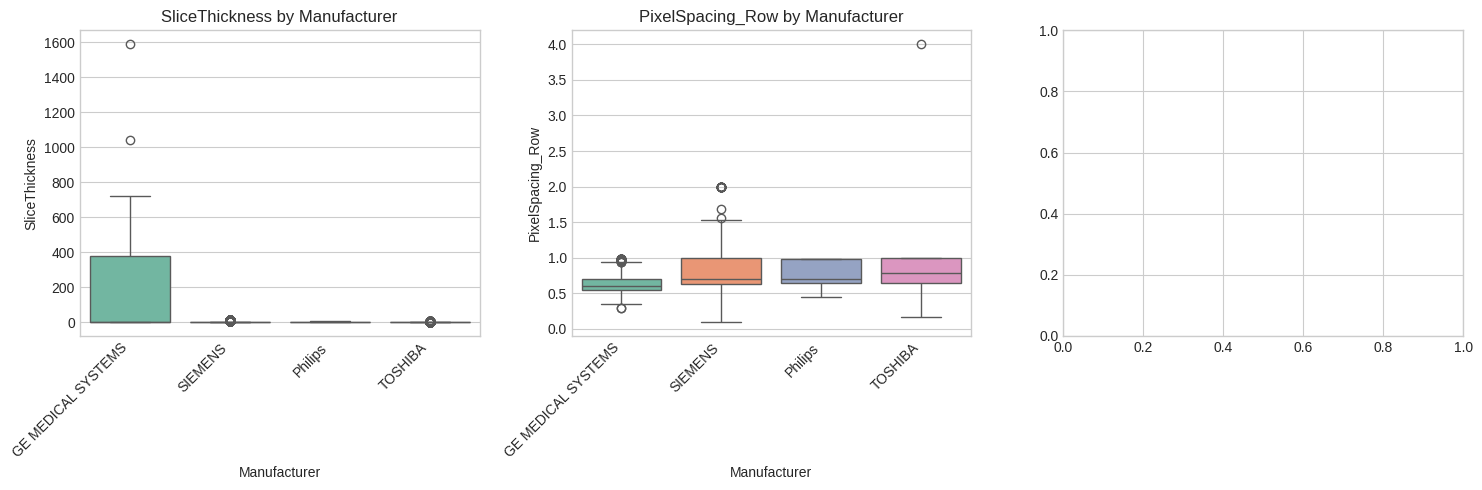

In [ ]:
# Spatial parameters by manufacturer

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
mfr_counts = series_df['Manufacturer'].value_counts(dropna=False)
valid_mfrs = mfr_counts[mfr_counts > 100].index

plot_df = series_df[series_df['Manufacturer'].isin(valid_mfrs)].copy()

order = plot_df['Manufacturer'].value_counts().index

for i, col in enumerate(spatial_cols):
    ax = axes[i]

    if col not in plot_df.columns:
        ax.set_title(f"{col} not in DataFrame")
        ax.axis("off")
        continue

    tmp = plot_df.dropna(subset=[col])

    sns.boxplot(
        data=tmp,
        x='Manufacturer',
        y=col,
        ax=ax,
        order=order,
        palette='Set2'
    )

    ax.set_title(f'{col} by Manufacturer')
    ax.set_xlabel('Manufacturer')
    ax.set_ylabel(col)

    ax.tick_params(axis='x', rotation=45)
    for label in ax.get_xticklabels():
        label.set_ha('right')

plt.tight_layout()
plt.show()


### 3.2 Contrast/Exposure Parameters

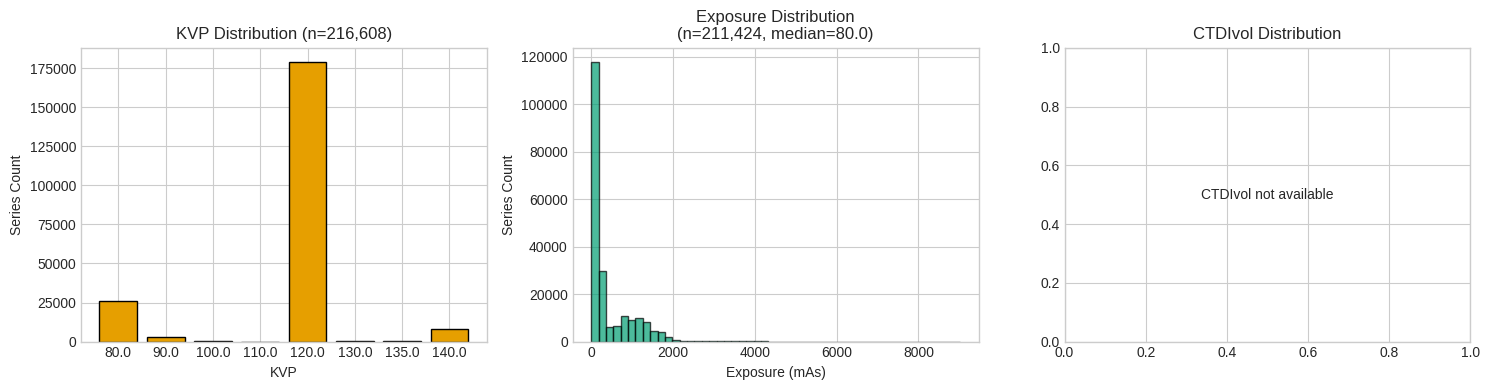

In [ ]:
# KVP distribution (typically discrete values)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# KVP bar chart
ax1 = axes[0]
kvp_counts = series_df['KVP'].value_counts().sort_index()
ax1.bar(kvp_counts.index.astype(str), kvp_counts.values, color='#E69F00', edgecolor='black')
ax1.set_xlabel('KVP')
ax1.set_ylabel('Series Count')
ax1.set_title(f'KVP Distribution (n={series_df["KVP"].notna().sum():,})')

# Exposure histogram
ax2 = axes[1]
exposure_data = series_df['Exposure'].dropna()
ax2.hist(exposure_data, bins=50, edgecolor='black', alpha=0.7, color='#009E73')
ax2.set_xlabel('Exposure (mAs)')
ax2.set_ylabel('Series Count')
ax2.set_title(f'Exposure Distribution\n(n={len(exposure_data):,}, median={exposure_data.median():.1f})')

# CTDIvol histogram
ax3 = axes[2]
ctdi_data = series_df['CTDIvol'].dropna()
if len(ctdi_data) > 0:
    ax3.hist(ctdi_data, bins=50, edgecolor='black', alpha=0.7, color='#D55E00')
    ax3.set_xlabel('CTDIvol (mGy)')
    ax3.set_ylabel('Series Count')
    ax3.set_title(f'CTDIvol Distribution\n(n={len(ctdi_data):,}, median={ctdi_data.median():.1f})')
else:
    ax3.text(0.5, 0.5, 'CTDIvol not available', ha='center', va='center', transform=ax3.transAxes)
    ax3.set_title('CTDIvol Distribution')

plt.tight_layout()
plt.show()

In [ ]:
# Exposure vs CTDIvol correlation (if both available)
if series_df['CTDIvol'].notna().sum() > 100 and series_df['Exposure'].notna().sum() > 100:
    fig, ax = plt.subplots(figsize=(8, 6))

    valid_data = series_df[['Exposure', 'CTDIvol']].dropna()
    ax.scatter(valid_data['Exposure'], valid_data['CTDIvol'], alpha=0.3, s=10, c='#0072B2')

    # Calculate correlation
    corr, p_val = stats.spearmanr(valid_data['Exposure'], valid_data['CTDIvol'])
    ax.set_xlabel('Exposure (mAs)')
    ax.set_ylabel('CTDIvol (mGy)')
    ax.set_title(f'Exposure vs CTDIvol\n(Spearman r = {corr:.3f}, p < 0.001)')

    plt.tight_layout()
    plt.show()
else:
    print("Insufficient data for Exposure vs CTDIvol comparison")

Insufficient data for Exposure vs CTDIvol comparison


### 3.3 Reconstruction Kernels

In [ ]:
# Convolution kernel distribution
kernel_counts = series_df['ConvolutionKernel'].value_counts()
print(f"Total unique convolution kernels: {len(kernel_counts)}")
print(f"\nTop 20 kernels:")
print(kernel_counts.head(20))

Total unique convolution kernels: 4969

Top 20 kernels:
ConvolutionKernel
[STANDARD]         56957
[B30f]             31809
[B50f]             24874
[EXPERIMENTAL7]    22436
[T20s]             22248
[BONE]             20241
[C]                10560
[FL01]              4993
[FC51]              4790
[LUNG]              4729
[D]                 3202
[FC10]              1504
[B80f]               838
[B]                  583
[FC11]               395
[FC30]               384
[FC01]               237
[A]                  165
[B60f]               140
[B70f]               133
Name: count, dtype: int64


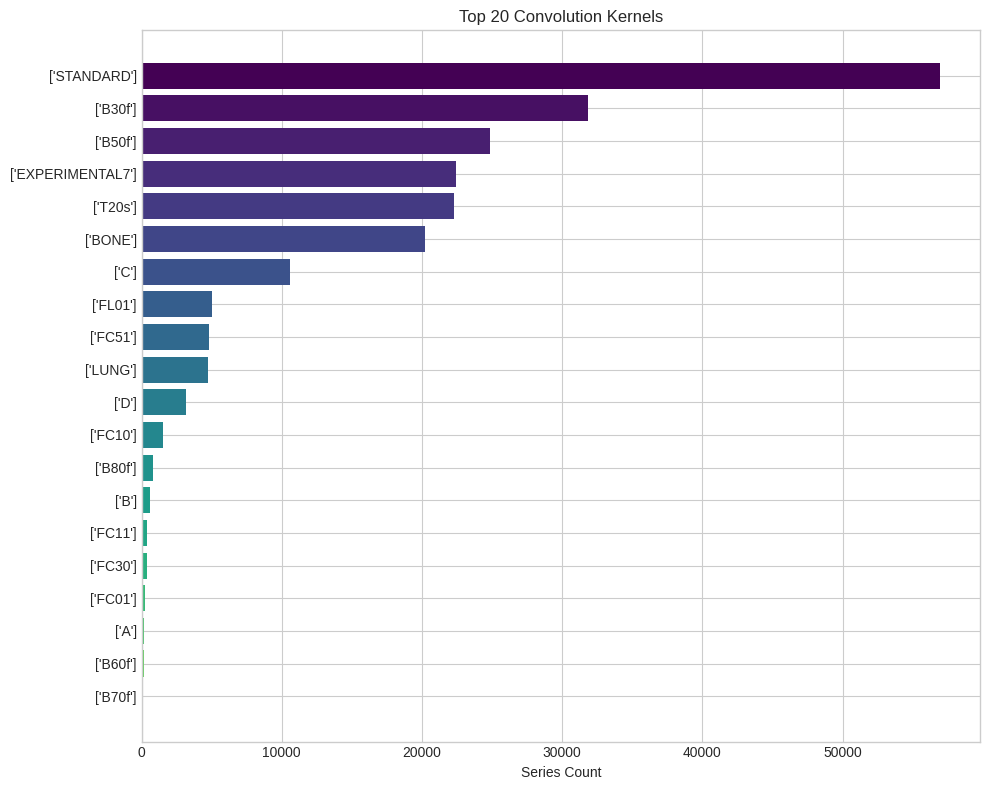

In [ ]:
# Top 20 kernels bar chart
fig, ax = plt.subplots(figsize=(10, 8))

top_kernels = kernel_counts.head(20)
colors = plt.cm.viridis(np.linspace(0, 0.8, len(top_kernels)))
ax.barh(range(len(top_kernels)), top_kernels.values, color=colors)
ax.set_yticks(range(len(top_kernels)))
ax.set_yticklabels(top_kernels.index)
ax.set_xlabel('Series Count')
ax.set_title('Top 20 Convolution Kernels')
ax.invert_yaxis()

plt.tight_layout()
plt.show()

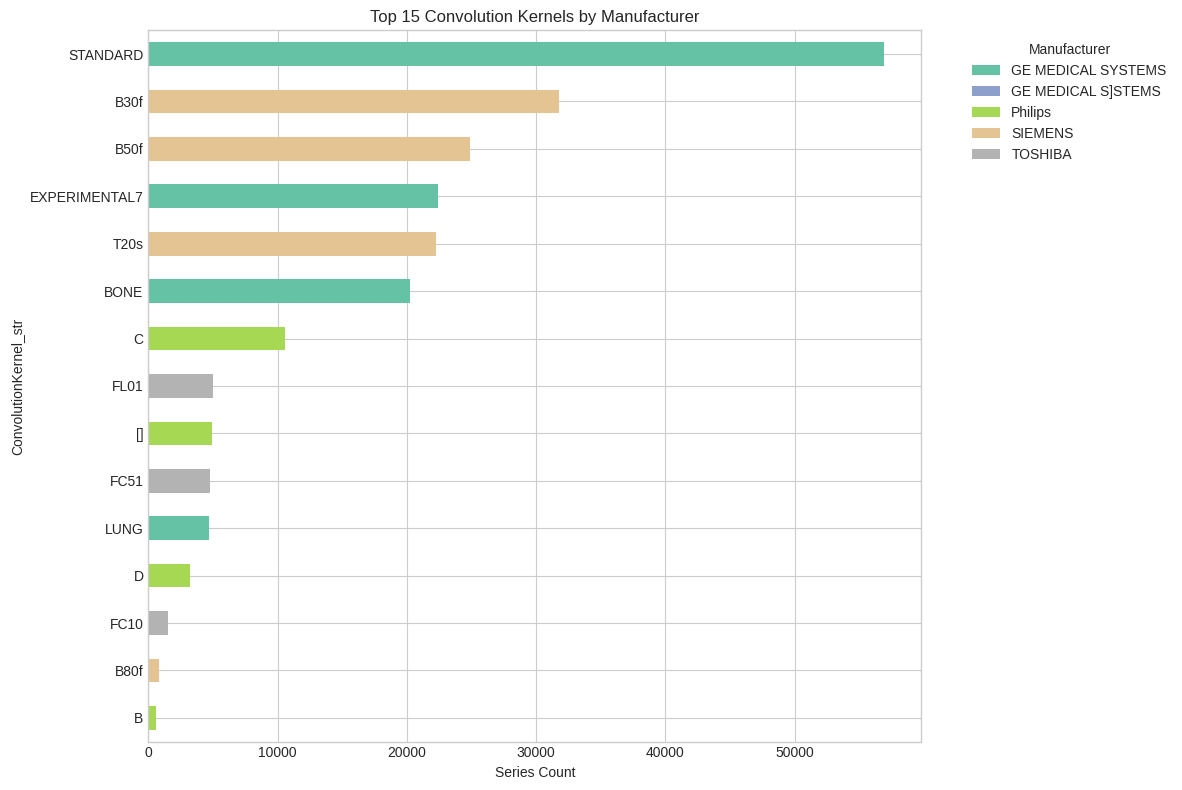

In [ ]:
# Kernels by manufacturer (stacked)
# Convert ConvolutionKernel entries to hashable strings
series_df['ConvolutionKernel_str'] = series_df['ConvolutionKernel'].apply(lambda x: x[0] if isinstance(x, np.ndarray) and len(x) > 0 else str(x))

kernel_mfr = series_df.groupby(['ConvolutionKernel_str', 'Manufacturer']).size().unstack(fill_value=0)

# Ensure top_kernels from the previous cell is also based on the string representation
kernel_counts_str = series_df['ConvolutionKernel_str'].value_counts()
top_kernel_mfr = kernel_mfr.loc[kernel_counts_str.head(15).index]

fig, ax = plt.subplots(figsize=(12, 8))
top_kernel_mfr.plot(kind='barh', stacked=True, ax=ax, colormap='Set2')
ax.set_xlabel('Series Count')
ax.set_title('Top 15 Convolution Kernels by Manufacturer')
ax.legend(title='Manufacturer', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.invert_yaxis()

plt.tight_layout()
plt.show()

### 3.4 Hardware (Manufacturer & Model)

In [ ]:
# Manufacturer distribution
mfr_counts = series_df['Manufacturer'].value_counts()
print("Manufacturer Distribution:")
print(mfr_counts)

Manufacturer Distribution:
Manufacturer
GE MEDICAL SYSTEMS    104387
SIEMENS                80261
Philips                19422
TOSHIBA                12540
GE MEDICAL S]STEMS         1
Name: count, dtype: int64


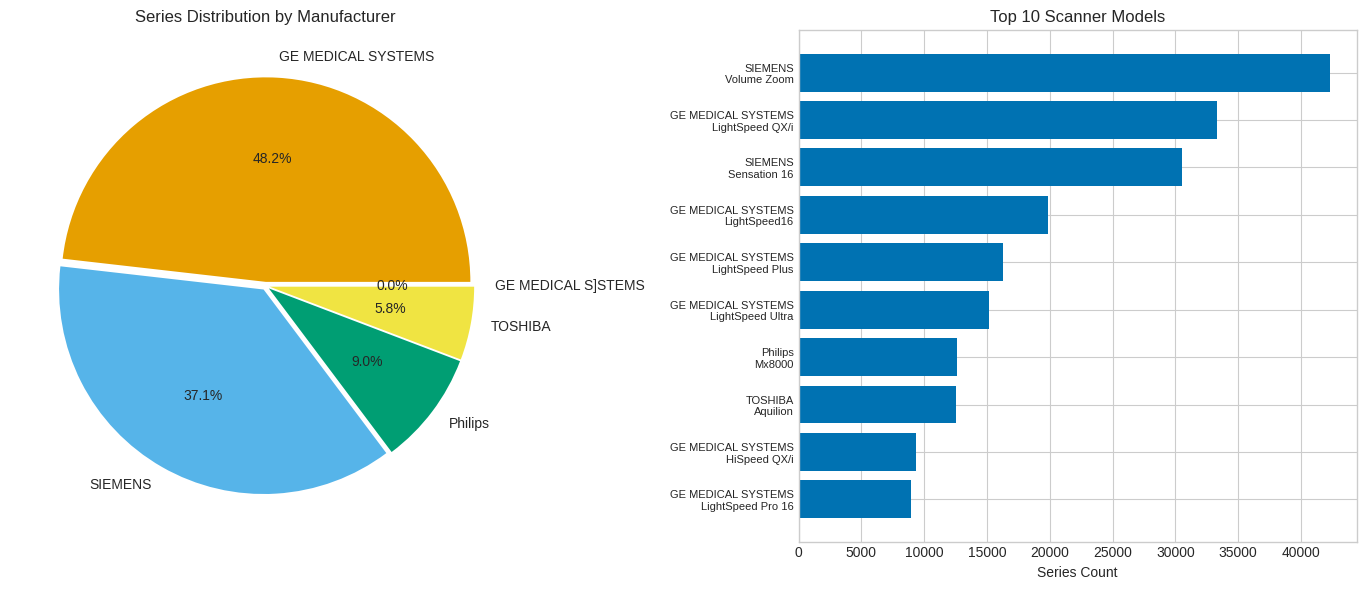

In [ ]:
# Manufacturer pie chart and model bar chart
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Pie chart
ax1 = axes[0]
colors = ['#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7']
wedges, texts, autotexts = ax1.pie(
    mfr_counts.values,
    labels=mfr_counts.index,
    autopct='%1.1f%%',
    colors=colors[:len(mfr_counts)],
    explode=[0.02] * len(mfr_counts)
)
ax1.set_title('Series Distribution by Manufacturer')

# Top models bar chart
ax2 = axes[1]
model_counts = series_df.groupby(['Manufacturer', 'ManufacturerModelName']).size().sort_values(ascending=False)
top_models = model_counts.head(10)
model_labels = [f"{m[0]}\n{m[1]}" if m[1] else m[0] for m in top_models.index]

ax2.barh(range(len(top_models)), top_models.values, color='#0072B2')
ax2.set_yticks(range(len(top_models)))
ax2.set_yticklabels(model_labels, fontsize=8)
ax2.set_xlabel('Series Count')
ax2.set_title('Top 10 Scanner Models')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

### 3.5 Geometry Parameters

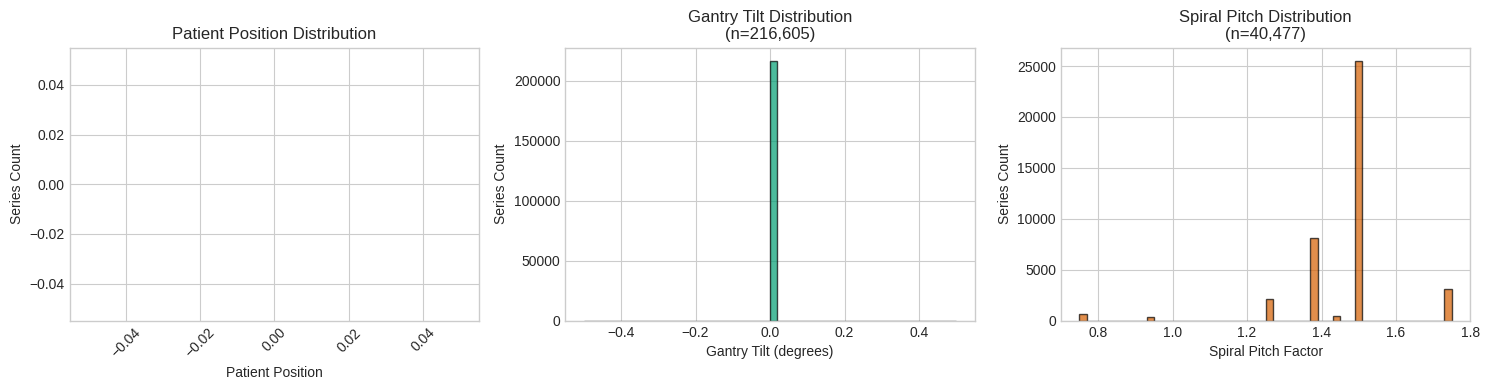

In [ ]:
# Geometry parameters
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Patient Position
ax1 = axes[0]
pos_counts = series_df['PatientPosition'].value_counts()
ax1.bar(pos_counts.index.astype(str), pos_counts.values, color='#56B4E9', edgecolor='black')
ax1.set_xlabel('Patient Position')
ax1.set_ylabel('Series Count')
ax1.set_title('Patient Position Distribution')
ax1.tick_params(axis='x', rotation=45)

# Gantry Detector Tilt
ax2 = axes[1]
tilt_data = series_df['GantryDetectorTilt'].dropna()
if len(tilt_data) > 0:
    ax2.hist(tilt_data, bins=50, edgecolor='black', alpha=0.7, color='#009E73')
    ax2.set_xlabel('Gantry Tilt (degrees)')
    ax2.set_ylabel('Series Count')
    ax2.set_title(f'Gantry Tilt Distribution\n(n={len(tilt_data):,})')
else:
    ax2.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax2.transAxes)

# Spiral Pitch Factor
ax3 = axes[2]
pitch_data = series_df['SpiralPitchFactor'].dropna()
if len(pitch_data) > 0:
    ax3.hist(pitch_data, bins=50, edgecolor='black', alpha=0.7, color='#D55E00')
    ax3.set_xlabel('Spiral Pitch Factor')
    ax3.set_ylabel('Series Count')
    ax3.set_title(f'Spiral Pitch Distribution\n(n={len(pitch_data):,})')
else:
    ax3.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax3.transAxes)

plt.tight_layout()
plt.show()

## Section 4: Statistical Assumption Checking & Correlation Analysis

### 4.1 Distribution Analysis (Before Statistical Tests)

In [ ]:
# Build continuous columns from filtered attributes (excludes columns with >80% null)
continuous_cols = []
for category in ['spatial', 'exposure', 'geometry']:
    if category in DICOM_ATTRIBUTES_FILTERED:
        continuous_cols.extend(DICOM_ATTRIBUTES_FILTERED[category])

# Filter to columns with sufficient data in the loaded DataFrame
continuous_cols_valid = [col for col in continuous_cols
                         if col in series_df.columns and series_df[col].notna().sum() > 100]

print(f"Continuous variables from filtered attributes: {continuous_cols}")
print(f"Continuous variables with sufficient data: {continuous_cols_valid}")

Continuous variables from filtered attributes: ['SliceThickness', 'PixelSpacing_Row', 'KVP', 'Exposure', 'GantryDetectorTilt']
Continuous variables with sufficient data: ['SliceThickness', 'PixelSpacing_Row', 'KVP', 'Exposure', 'GantryDetectorTilt']


In [ ]:
# Normality tests
def test_normality(data, name, max_samples=5000):
    """Test normality using D'Agostino-Pearson test (robust for large samples)."""
    data = data.dropna()
    if len(data) > max_samples:
        data = data.sample(n=max_samples, random_state=42)

    if len(data) < 20:
        return {'variable': name, 'n': len(data), 'statistic': np.nan,
                'p_value': np.nan, 'is_normal': 'Insufficient data'}

    try:
        stat, p_value = stats.normaltest(data)
        is_normal = 'Yes' if p_value > 0.05 else 'No'
    except:
        stat, p_value, is_normal = np.nan, np.nan, 'Test failed'

    return {'variable': name, 'n': len(data), 'statistic': stat,
            'p_value': p_value, 'is_normal': is_normal}

normality_results = [test_normality(series_df[col], col) for col in continuous_cols_valid]
normality_df = pd.DataFrame(normality_results)
print("Normality Test Results (D'Agostino-Pearson):")
print(normality_df.to_string(index=False))
print("\nNote: With large samples, even small deviations from normality are significant.")
print("Consider visual inspection (Q-Q plots) and practical significance.")

Normality Test Results (D'Agostino-Pearson):
          variable    n   statistic       p_value is_normal
    SliceThickness 5000 1415.137787 5.090191e-308        No
  PixelSpacing_Row 5000  643.850287 1.547700e-140        No
               KVP 5000 1574.022420  0.000000e+00        No
          Exposure 5000 1669.259543  0.000000e+00        No
GantryDetectorTilt 5000         NaN           NaN        No

Note: With large samples, even small deviations from normality are significant.
Consider visual inspection (Q-Q plots) and practical significance.


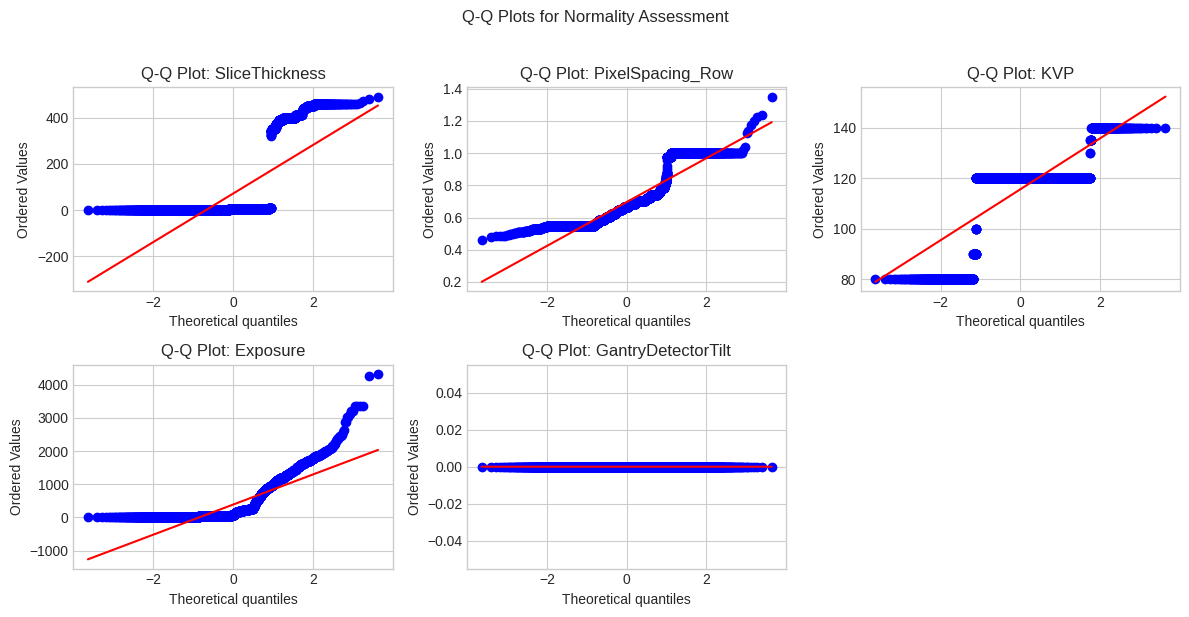

In [ ]:
# Q-Q plots for visual normality assessment
n_cols = len(continuous_cols_valid)
n_rows = (n_cols + 2) // 3
fig, axes = plt.subplots(n_rows, 3, figsize=(12, 3*n_rows))
axes = axes.flatten() if n_cols > 1 else [axes]

for i, col in enumerate(continuous_cols_valid):
    ax = axes[i]
    data = series_df[col].dropna()
    if len(data) > 5000:
        data = data.sample(n=5000, random_state=42)

    stats.probplot(data, dist="norm", plot=ax)
    ax.set_title(f'Q-Q Plot: {col}')

# Hide unused subplots
for i in range(len(continuous_cols_valid), len(axes)):
    axes[i].set_visible(False)

plt.suptitle('Q-Q Plots for Normality Assessment', y=1.02, fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
# Homoscedasticity test (Levene's test) for key variables across manufacturers
def test_homoscedasticity(df, var, group_var='Manufacturer'):
    """Test variance equality across groups using Levene's test."""
    groups = [group[var].dropna().values for name, group in df.groupby(group_var)]
    groups = [g for g in groups if len(g) > 1]

    if len(groups) < 2:
        return {'variable': var, 'statistic': np.nan, 'p_value': np.nan, 'equal_variance': 'Insufficient groups'}

    try:
        stat, p_value = stats.levene(*groups)
        equal_var = 'Yes' if p_value > 0.05 else 'No'
    except:
        stat, p_value, equal_var = np.nan, np.nan, 'Test failed'

    return {'variable': var, 'statistic': stat, 'p_value': p_value, 'equal_variance': equal_var}

homoscedasticity_results = [test_homoscedasticity(series_df, col) for col in continuous_cols_valid]
homoscedasticity_df = pd.DataFrame(homoscedasticity_results)
print("Homoscedasticity Test Results (Levene's Test):")
print(homoscedasticity_df.to_string(index=False))

Homoscedasticity Test Results (Levene's Test):
          variable    statistic       p_value equal_variance
    SliceThickness 20561.434126  0.000000e+00             No
  PixelSpacing_Row 10537.714934  0.000000e+00             No
               KVP   237.294806 9.948936e-154             No
          Exposure 55619.991843  0.000000e+00             No
GantryDetectorTilt     3.397884  1.699145e-02             No


In [ ]:
# Summary: Recommended statistical tests based on assumptions
print("\n" + "="*60)
print("STATISTICAL TEST RECOMMENDATIONS")
print("="*60)
print("\nBased on the normality and homoscedasticity tests:")
print("\n1. CORRELATIONS:")
print("   - Most variables are non-normal → Use Spearman correlation")
print("\n2. GROUP COMPARISONS (by Manufacturer):")
print("   - Non-normal distributions and unequal variances → Use Kruskal-Wallis")
print("\n3. CATEGORICAL ASSOCIATIONS:")
print("   - Check expected cell counts before Chi-square test")
print("   - If expected counts < 5 in >20% cells → Combine categories")


STATISTICAL TEST RECOMMENDATIONS

Based on the normality and homoscedasticity tests:

1. CORRELATIONS:
   - Most variables are non-normal → Use Spearman correlation

2. GROUP COMPARISONS (by Manufacturer):
   - Non-normal distributions and unequal variances → Use Kruskal-Wallis

3. CATEGORICAL ASSOCIATIONS:
   - Check expected cell counts before Chi-square test
   - If expected counts < 5 in >20% cells → Combine categories


### 4.2 Correlation Analysis

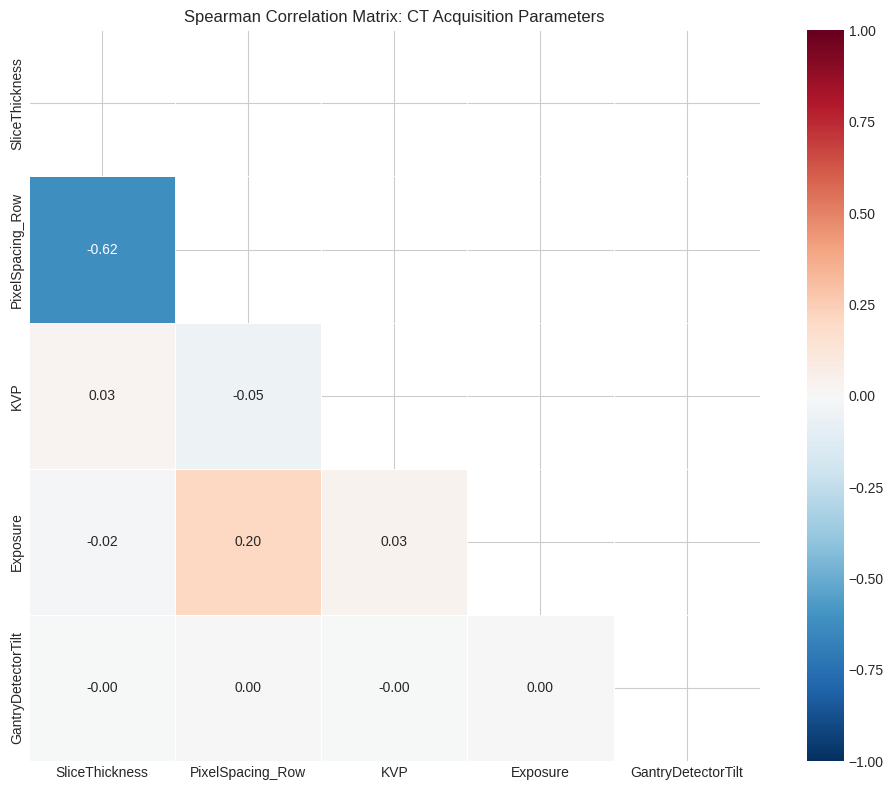

In [ ]:
# Spearman correlation matrix (robust to non-normality)
corr_data = series_df[continuous_cols_valid].dropna()
if len(corr_data) > 0:
    corr_matrix = corr_data.corr(method='spearman')

    # Create mask for upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(
        corr_matrix,
        mask=mask,
        annot=True,
        fmt='.2f',
        cmap='RdBu_r',
        center=0,
        vmin=-1, vmax=1,
        square=True,
        linewidths=0.5,
        ax=ax
    )
    ax.set_title('Spearman Correlation Matrix: CT Acquisition Parameters', fontsize=12)
    plt.tight_layout()
    plt.show()
else:
    print("Insufficient data for correlation analysis")

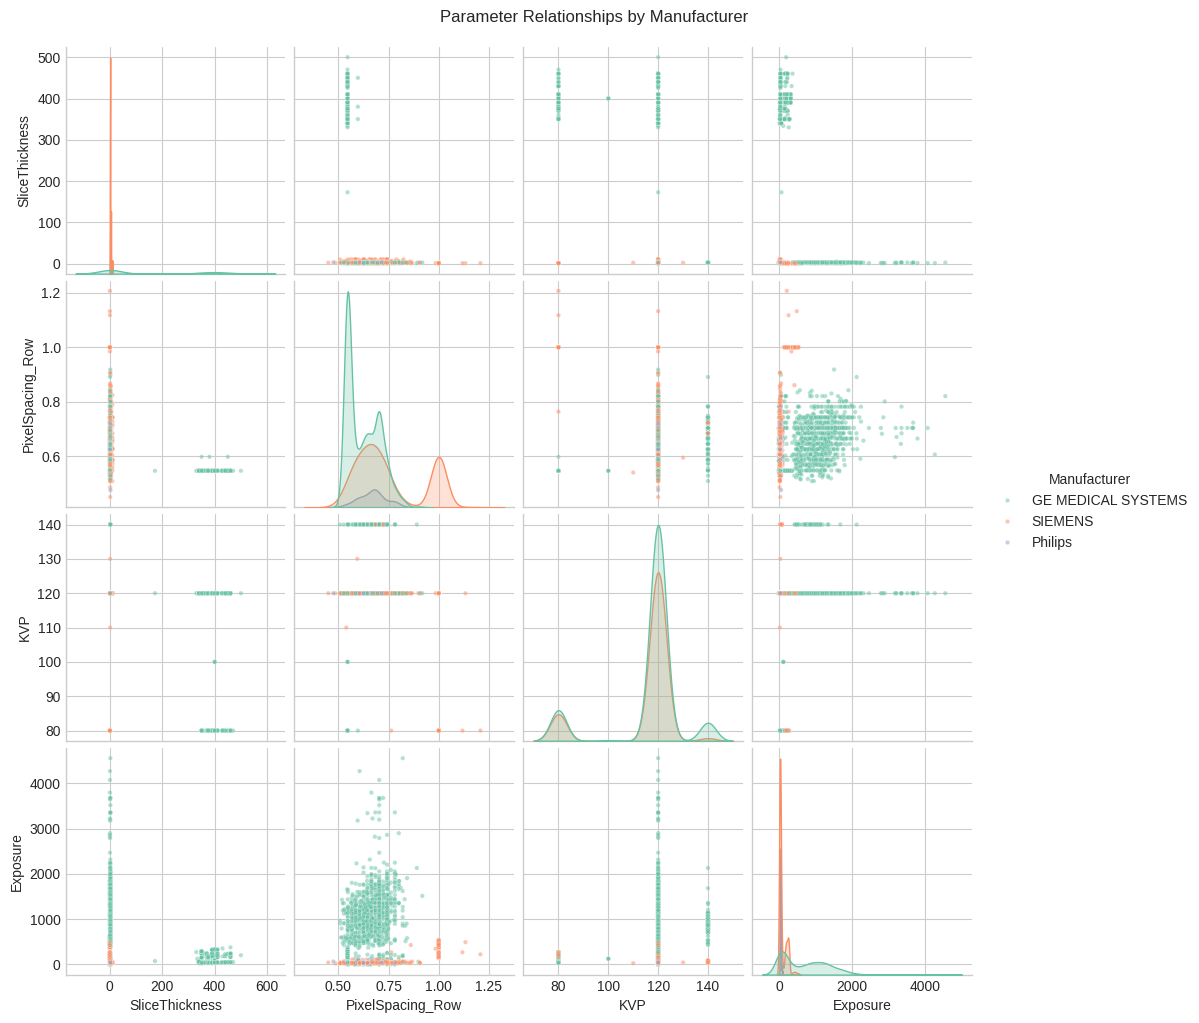

In [ ]:
# Pair plot (subsample for performance)
pairplot_cols = ['SliceThickness', 'PixelSpacing_Row', 'KVP', 'Exposure']
pairplot_cols = [c for c in pairplot_cols if c in continuous_cols_valid]

if len(pairplot_cols) >= 2:
    # Subsample and filter to main manufacturers
    top_mfrs = series_df['Manufacturer'].value_counts().head(3).index
    pairplot_data = series_df[series_df['Manufacturer'].isin(top_mfrs)][pairplot_cols + ['Manufacturer']].dropna()

    if len(pairplot_data) > 3000:
        pairplot_data = pairplot_data.sample(n=3000, random_state=42)

    g = sns.pairplot(
        pairplot_data,
        hue='Manufacturer',
        diag_kind='kde',
        plot_kws={'alpha': 0.5, 's': 10},
        palette='Set2'
    )
    g.fig.suptitle('Parameter Relationships by Manufacturer', y=1.02)
    plt.show()
else:
    print("Insufficient variables for pair plot")

### 4.3 Group Comparisons

In [ ]:
# Kruskal-Wallis test for continuous parameters across manufacturers
def kruskal_wallis_by_group(df, continuous_var, group_var='Manufacturer'):
    """Perform Kruskal-Wallis H-test for group comparisons."""
    groups = [group[continuous_var].dropna().values for name, group in df.groupby(group_var)]
    groups = [g for g in groups if len(g) > 1]

    if len(groups) < 2:
        return {'variable': continuous_var, 'H_statistic': np.nan, 'p_value': np.nan, 'n_groups': len(groups)}

    try:
        h_stat, p_value = stats.kruskal(*groups)

        # Calculate effect size (epsilon-squared)
        n_total = sum(len(g) for g in groups)
        epsilon_sq = (h_stat - len(groups) + 1) / (n_total - len(groups))
        epsilon_sq = max(0, epsilon_sq)  # Ensure non-negative

    except:
        h_stat, p_value, epsilon_sq = np.nan, np.nan, np.nan

    return {'variable': continuous_var, 'H_statistic': h_stat, 'p_value': p_value,
            'epsilon_squared': epsilon_sq, 'n_groups': len(groups)}

kruskal_results = [kruskal_wallis_by_group(series_df, col) for col in continuous_cols_valid]
kruskal_df = pd.DataFrame(kruskal_results)
print("Kruskal-Wallis Test Results (by Manufacturer):")
print(kruskal_df.to_string(index=False))
print("\nEffect size interpretation (epsilon-squared):")
print("  Small: < 0.01, Medium: 0.01-0.06, Large: > 0.14")

Kruskal-Wallis Test Results (by Manufacturer):
          variable  H_statistic  p_value  epsilon_squared  n_groups
    SliceThickness 77359.409528 0.000000         0.357135         4
  PixelSpacing_Row 42652.613916 0.000000         0.196902         4
               KVP  2198.504514 0.000000         0.010136         4
          Exposure 74130.055369 0.000000         0.350617         4
GantryDetectorTilt     1.132591 0.769213         0.000000         4

Effect size interpretation (epsilon-squared):
  Small: < 0.01, Medium: 0.01-0.06, Large: > 0.14


In [ ]:
# Chi-square test for categorical associations (Manufacturer vs ConvolutionKernel)
def chi_square_with_check(df, var1, var2, min_expected=5):
    """Perform chi-square test with expected count validation."""
    contingency = pd.crosstab(df[var1].fillna('Missing'), df[var2].fillna('Missing'))

    chi2, p_value, dof, expected = stats.chi2_contingency(contingency)

    # Check expected counts
    pct_low_expected = (expected < min_expected).sum() / expected.size * 100

    # Calculate Cramer's V
    n = contingency.sum().sum()
    min_dim = min(contingency.shape) - 1
    cramers_v = np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else 0

    return {
        'chi2': chi2,
        'p_value': p_value,
        'dof': dof,
        'cramers_v': cramers_v,
        'pct_low_expected': pct_low_expected,
        'valid_test': pct_low_expected < 20
    }

# Test Manufacturer vs ConvolutionKernel (top categories only)
# Use the 'ConvolutionKernel_str' column which contains string representations
top_kernels = series_df['ConvolutionKernel_str'].value_counts().head(10).index
filtered_df = series_df[series_df['ConvolutionKernel_str'].isin(top_kernels)].copy() # Use .copy() to avoid SettingWithCopyWarning

chi2_result = chi_square_with_check(filtered_df, 'Manufacturer', 'ConvolutionKernel_str')
print("Chi-Square Test: Manufacturer vs ConvolutionKernel (top 10 kernels)")
print(f"  Chi-square statistic: {chi2_result['chi2']:.2f}")
print(f"  p-value: {chi2_result['p_value']:.2e}")
print(f"  Degrees of freedom: {chi2_result['dof']}")
print(f"  Cramer's V (effect size): {chi2_result['cramers_v']:.3f}")
print(f"  % cells with expected count < 5: {chi2_result['pct_low_expected']:.1f}%")
print(f"  Test valid: {chi2_result['valid_test']}")

Chi-Square Test: Manufacturer vs ConvolutionKernel (top 10 kernels)
  Chi-square statistic: 611189.53
  p-value: 0.00e+00
  Degrees of freedom: 36
  Cramer's V (effect size): 0.866
  % cells with expected count < 5: 20.0%
  Test valid: False


## Section 5: Clustering for Representative Subsets

In [ ]:
# Prepare features for clustering
def prepare_clustering_features(df, numeric_cols, categorical_cols, top_n_categories=10):
    """Prepare feature matrix for clustering."""
    # Start with a copy
    df_clean = df.copy()

    # Filter to rows with sufficient numeric data
    valid_numeric = [col for col in numeric_cols if col in df_clean.columns]
    df_clean = df_clean.dropna(subset=valid_numeric, how='all')

    # Fill remaining NaN with median
    for col in valid_numeric:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].fillna(df_clean[col].median())

    # Encode categorical variables (top N + 'Other')
    for col in categorical_cols:
        if col in df_clean.columns:
            top_cats = df_clean[col].value_counts().nlargest(top_n_categories).index
            df_clean[f'{col}_encoded'] = df_clean[col].apply(
                lambda x: x if x in top_cats else 'Other'
            )

    # Create feature matrix
    X_numeric = df_clean[valid_numeric]

    cat_encoded_cols = [f'{c}_encoded' for c in categorical_cols if f'{c}_encoded' in df_clean.columns]
    X_cat = pd.get_dummies(df_clean[cat_encoded_cols], drop_first=True)

    X = pd.concat([X_numeric, X_cat], axis=1)

    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, X.columns.tolist(), df_clean, scaler

# Extract numeric features from filtered attributes (excludes columns with >80% null)
numeric_features = []
for category in ['spatial', 'exposure', 'geometry']:
    if category in DICOM_ATTRIBUTES_FILTERED:
        numeric_features.extend(DICOM_ATTRIBUTES_FILTERED[category])

# Filter to columns with sufficient data in the loaded DataFrame
numeric_features = [f for f in numeric_features
                    if f in series_df.columns and series_df[f].notna().sum() > 100]

categorical_features = ['Manufacturer', 'ConvolutionKernel_str'] # Changed from 'ConvolutionKernel' to 'ConvolutionKernel_str'

print(f"Numeric features (from filtered attributes): {numeric_features}")
print(f"Categorical features: {categorical_features}")

X_scaled, feature_names, df_clean, scaler = prepare_clustering_features(
    series_df, numeric_features, categorical_features
)

print(f"\nFeature matrix shape: {X_scaled.shape}")
print(f"Total features: {len(feature_names)}")

Numeric features (from filtered attributes): ['SliceThickness', 'PixelSpacing_Row', 'KVP', 'Exposure', 'GantryDetectorTilt']
Categorical features: ['Manufacturer', 'ConvolutionKernel_str']

Feature matrix shape: (216608, 19)
Total features: 19


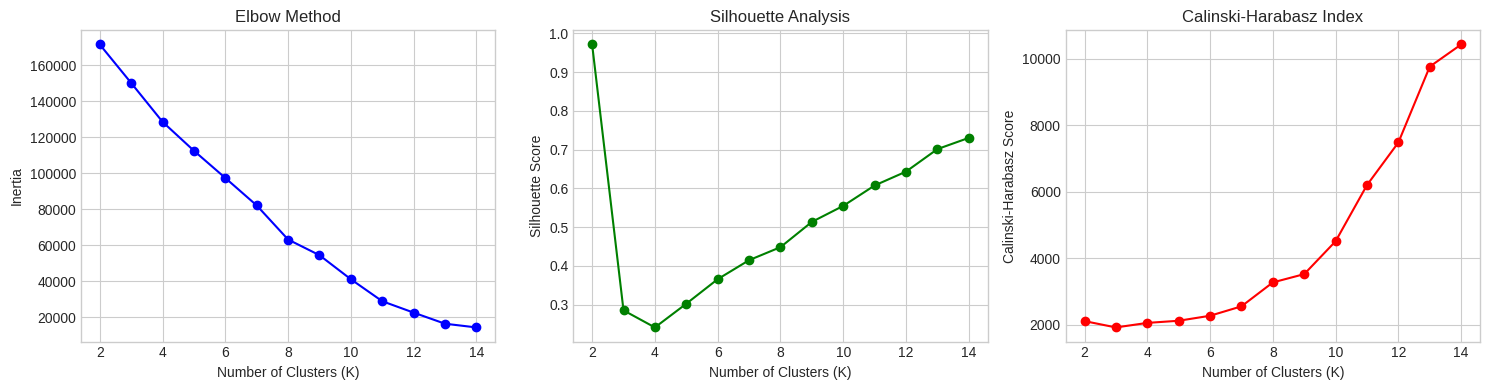

Recommended K based on silhouette score: 2


In [ ]:
# Find optimal number of clusters
def find_optimal_clusters(X, k_range=range(2, 15)):
    """Determine optimal number of clusters using multiple metrics."""
    inertias = []
    silhouettes = []
    calinski = []

    # Subsample for faster computation if needed
    if len(X) > 10000:
        np.random.seed(42)
        idx = np.random.choice(len(X), 10000, replace=False)
        X_sample = X[idx]
    else:
        X_sample = X

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_sample)

        inertias.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(X_sample, labels))
        calinski.append(calinski_harabasz_score(X_sample, labels))

    # Plot metrics
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    axes[0].plot(k_range, inertias, 'bo-')
    axes[0].set_xlabel('Number of Clusters (K)')
    axes[0].set_ylabel('Inertia')
    axes[0].set_title('Elbow Method')

    axes[1].plot(k_range, silhouettes, 'go-')
    axes[1].set_xlabel('Number of Clusters (K)')
    axes[1].set_ylabel('Silhouette Score')
    axes[1].set_title('Silhouette Analysis')

    axes[2].plot(k_range, calinski, 'ro-')
    axes[2].set_xlabel('Number of Clusters (K)')
    axes[2].set_ylabel('Calinski-Harabasz Score')
    axes[2].set_title('Calinski-Harabasz Index')

    plt.tight_layout()
    plt.show()

    # Recommend K based on silhouette score
    best_k = list(k_range)[np.argmax(silhouettes)]
    print(f"Recommended K based on silhouette score: {best_k}")

    return {'k_range': list(k_range), 'silhouettes': silhouettes, 'best_k': best_k}

cluster_metrics = find_optimal_clusters(X_scaled)

In [ ]:
# User can override the recommended K
n_clusters = cluster_metrics['best_k']  # Or set manually: n_clusters = 8
print(f"Using {n_clusters} clusters")

Using 2 clusters


In [ ]:
# Perform clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to dataframe
df_clean['Cluster'] = labels

print(f"Cluster sizes:")
print(df_clean['Cluster'].value_counts().sort_index())

Cluster sizes:
Cluster
0    136346
1     80262
Name: count, dtype: int64


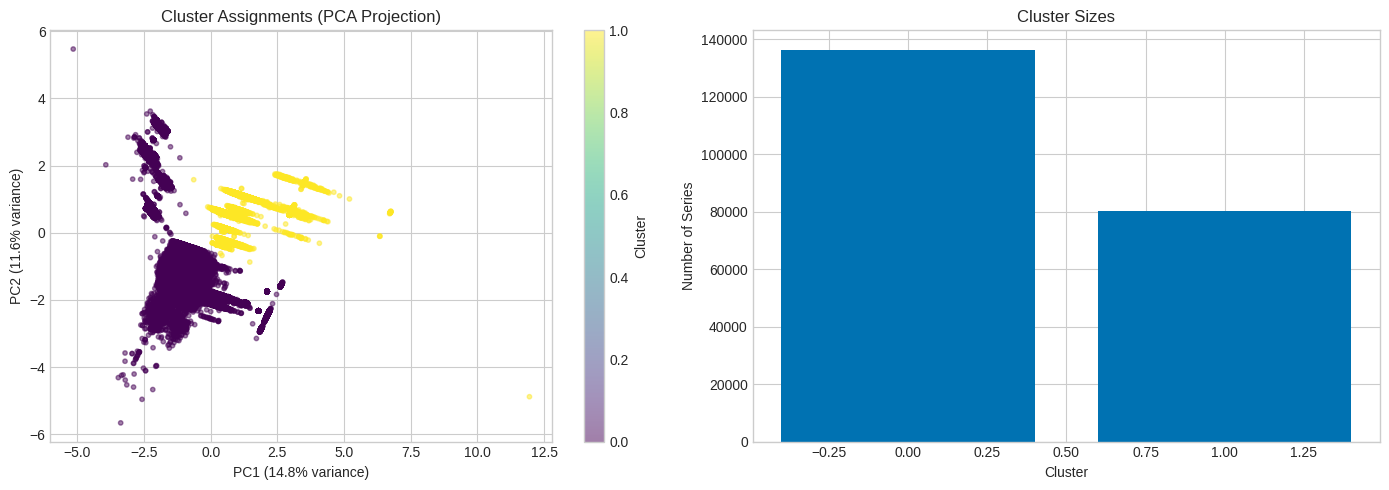

In [ ]:
# PCA visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# PCA scatter plot
scatter = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=labels,
                           cmap='viridis', alpha=0.5, s=10)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
axes[0].set_title('Cluster Assignments (PCA Projection)')
plt.colorbar(scatter, ax=axes[0], label='Cluster')

# Cluster sizes bar chart
cluster_counts = df_clean['Cluster'].value_counts().sort_index()
axes[1].bar(cluster_counts.index, cluster_counts.values, color='#0072B2')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Number of Series')
axes[1].set_title('Cluster Sizes')

plt.tight_layout()
plt.show()

In [ ]:
# Characterize clusters
def characterize_clusters(df, numeric_cols, categorical_cols):
    """Generate summary statistics for each cluster."""
    # Numeric summary
    numeric_summary = df.groupby('Cluster')[numeric_cols].agg(['mean', 'std', 'median'])

    # Categorical summary (mode)
    cat_summary = {}
    for col in categorical_cols:
        if col in df.columns:
            mode_df = df.groupby('Cluster')[col].agg(
                lambda x: x.value_counts().index[0] if len(x) > 0 and x.notna().any() else None
            )
            cat_summary[col] = mode_df

    return numeric_summary, pd.DataFrame(cat_summary)

numeric_summary, cat_summary = characterize_clusters(df_clean, numeric_features, categorical_features)

print("Cluster Characterization - Numeric Features (Mean):")
print(numeric_summary.xs('mean', axis=1, level=1).round(2).to_string())
print("\nCluster Characterization - Categorical Features (Mode):")
print(cat_summary.to_string())

Cluster Characterization - Numeric Features (Mean):
         SliceThickness  PixelSpacing_Row     KVP  Exposure  GantryDetectorTilt
Cluster                                                                        
0                111.84              0.66  116.28    578.02                 0.0
1                  2.31              0.75  114.48     91.45                -0.0

Cluster Characterization - Categorical Features (Mode):
               Manufacturer ConvolutionKernel_str
Cluster                                          
0        GE MEDICAL SYSTEMS              STANDARD
1                   SIEMENS                  B30f


In [ ]:
# Select representative series from each cluster
def select_representatives(X, labels, df_original, n_per_cluster=10):
    """Select series closest to cluster centroids."""
    representatives = []

    for cluster_id in range(labels.max() + 1):
        # Get cluster members
        cluster_mask = labels == cluster_id
        cluster_X = X[cluster_mask]
        cluster_df = df_original[cluster_mask].reset_index(drop=True)

        if len(cluster_df) == 0:
            continue

        # Calculate centroid
        centroid = cluster_X.mean(axis=0)

        # Calculate distances to centroid
        distances = np.linalg.norm(cluster_X - centroid, axis=1)

        # Select closest series
        n_select = min(n_per_cluster, len(cluster_df))
        closest_indices = distances.argsort()[:n_select]

        for idx in closest_indices:
            rep_series = cluster_df.iloc[idx].to_dict()
            rep_series['Distance_to_Centroid'] = distances[idx]
            representatives.append(rep_series)

    return pd.DataFrame(representatives)

n_per_cluster = CONFIG['n_representatives_per_cluster']
representatives_df = select_representatives(X_scaled, labels, df_clean, n_per_cluster)

print(f"Selected {len(representatives_df)} representative series")
print(f"\nRepresentatives per cluster:")
print(representatives_df['Cluster'].value_counts().sort_index())

Selected 20 representative series

Representatives per cluster:
Cluster
0    10
1    10
Name: count, dtype: int64


In [ ]:
# Preview representatives
display_cols = ['SeriesInstanceUID', 'Cluster', 'Manufacturer', 'ConvolutionKernel',
                'SliceThickness', 'KVP', 'Distance_to_Centroid']
display_cols = [c for c in display_cols if c in representatives_df.columns]
representatives_df[display_cols].head(20)

,SeriesInstanceUID,Cluster,Manufacturer,ConvolutionKernel,SliceThickness,KVP,Distance_to_Centroid
0,1.2.840.113654.2.55.96487372561936761970535612...,0,GE MEDICAL SYSTEMS,[STANDARD],2.5,120.0,1.931011
1,1.3.6.1.4.1.14519.5.2.1.7009.9004.222791394408...,0,GE MEDICAL SYSTEMS,[STANDARD],2.5,120.0,1.931142
2,1.3.6.1.4.1.14519.5.2.1.7009.9004.167010079577...,0,GE MEDICAL SYSTEMS,[STANDARD],2.5,120.0,1.931149
3,1.2.840.113654.2.55.15679477533043274971975169...,0,GE MEDICAL SYSTEMS,[STANDARD],2.5,120.0,1.931249
4,1.2.840.113654.2.55.28691667322591806058147711...,0,GE MEDICAL SYSTEMS,[STANDARD],2.5,120.0,1.931356
5,1.2.840.113654.2.55.62092362245861597176879099...,0,GE MEDICAL SYSTEMS,[STANDARD],2.5,120.0,1.931362
6,1.2.840.113654.2.55.28389542344376147180009890...,0,GE MEDICAL SYSTEMS,[STANDARD],2.5,120.0,1.931380
7,1.3.6.1.4.1.14519.5.2.1.7009.9004.204863242782...,0,GE MEDICAL SYSTEMS,[STANDARD],2.5,120.0,1.931386
8,1.2.840.113654.2.55.19357535084511983811619854...,0,GE MEDICAL SYSTEMS,[STANDARD],2.5,120.0,1.931386
9,1.2.840.113654.2.55.29468941825495698691804719...,0,GE MEDICAL SYSTEMS,[STANDARD],2.5,120.0,1.931386


## Section 6: Export

In [ ]:
import os

output_dir = './nlst_analysis_output'
os.makedirs(output_dir, exist_ok=True)

# Export cluster assignments (all series)
cluster_export_cols = ['SeriesInstanceUID', 'PatientID', 'Cluster', 'Manufacturer',
                       'ConvolutionKernel'] + numeric_features
cluster_export_cols = [c for c in cluster_export_cols if c in df_clean.columns]
df_clean[cluster_export_cols].to_csv(f'{output_dir}/all_series_clusters.csv', index=False)
print(f"Saved: {output_dir}/all_series_clusters.csv")

# Export representative series
representatives_df.to_csv(f'{output_dir}/representative_series.csv', index=False)
print(f"Saved: {output_dir}/representative_series.csv")

# Export Series UIDs only (for download)
uid_list = representatives_df['SeriesInstanceUID'].tolist()
with open(f'{output_dir}/representative_series_uids.txt', 'w') as f:
    f.write('\n'.join(uid_list))
print(f"Saved: {output_dir}/representative_series_uids.txt")

Saved: ./nlst_analysis_output/all_series_clusters.csv
Saved: ./nlst_analysis_output/representative_series.csv
Saved: ./nlst_analysis_output/representative_series_uids.txt


In [ ]:
# Generate download script for idc-index
download_script = f'''#!/usr/bin/env python3
"""
Download representative NLST CT series using idc-index.
Generated by NLST CT Acquisition Analysis notebook.
"""

from idc_index import IDCClient

# Initialize IDC client (no authentication required for downloads)
client = IDCClient()

# List of representative SeriesInstanceUIDs
series_uids = {repr(uid_list)}

# Download series
print(f"Downloading {{len(series_uids)}} representative series...")
client.download_from_selection(
    seriesInstanceUID=series_uids,
    downloadDir="./nlst_representative_series",
    dirTemplate="%collection_id/%PatientID/%SeriesInstanceUID"
)
print("Download complete!")
'''

with open(f'{output_dir}/download_representatives.py', 'w') as f:
    f.write(download_script)
print(f"Saved: {output_dir}/download_representatives.py")

Saved: ./nlst_analysis_output/download_representatives.py


In [ ]:
# Summary
print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)
print(f"\nTotal series analyzed: {len(df_clean):,}")
print(f"Number of clusters: {n_clusters}")
print(f"Representatives selected: {len(representatives_df)}")
print(f"\nOutput files:")
print(f"  - {output_dir}/all_series_clusters.csv")
print(f"  - {output_dir}/representative_series.csv")
print(f"  - {output_dir}/representative_series_uids.txt")
print(f"  - {output_dir}/download_representatives.py")
print("\nTo download the representative series, run:")
print(f"  python {output_dir}/download_representatives.py")


ANALYSIS COMPLETE

Total series analyzed: 216,608
Number of clusters: 2
Representatives selected: 20

Output files:
  - ./nlst_analysis_output/all_series_clusters.csv
  - ./nlst_analysis_output/representative_series.csv
  - ./nlst_analysis_output/representative_series_uids.txt
  - ./nlst_analysis_output/download_representatives.py

To download the representative series, run:
  python ./nlst_analysis_output/download_representatives.py
